In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

In [25]:
def pad_and_resize(image, target_size=(1024, 1024), resize_to=(224, 224)):
    old_size = image.size  # (width, height)
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.LANCZOS)
    new_image = Image.new("RGB", target_size, (0, 0, 0))
    new_image.paste(image, ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2))
    return new_image.resize(resize_to, Image.LANCZOS)

class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_test=False):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.class_mapping = {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 
                              'NV': 5, 'SCC': 6, 'VASC': 7}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if not self.is_test:
            img_path = os.path.join(self.root_dir, self.data.iloc[idx, 1])
            image = Image.open(img_path).convert('RGB')
            image = pad_and_resize(image)
            class_name = self.data.iloc[idx, 0]  
            label = self.class_mapping.get(class_name, -1)  
            label = torch.tensor(label, dtype=torch.long)
            if self.transform:
                image = self.transform(image)
            return image, label
        else:
            img_path = os.path.join(self.root_dir, self.data.iloc[idx, 4])
            image = Image.open(img_path).convert('RGB')
            image = pad_and_resize(image)
            if self.transform:
                image = self.transform(image)
            return image, self.data.iloc[idx, 0]

In [26]:
image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomErasing(p=0.7)
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [27]:
train_dataset = ImageDataset(
    csv_file='/kaggle/input/skincancer-isic2019/image_paths.csv',  
    root_dir='/kaggle/input/skincancer-isic2019/archive/archive',
    transform=train_transform
)

test_dataset = ImageDataset(
    csv_file='/kaggle/input/model-datatest-skincancer/test_data_remove_unk.csv', 
    root_dir='/kaggle/input/isic-2019-challenge/ISIC_2019_Test_Input/ISIC_2019_Test_Input', 
    transform=valid_transform, is_test=True)


In [28]:
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
trainset, validset = random_split(train_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(42))


batch_size = 32
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomDenseNet121, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        in_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training settings
criterion = nn.CrossEntropyLoss()

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomDenseNet121(num_classes=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def train_and_val_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    best_val_acc = 0.0
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        model.train()  
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_epoch_loss = running_loss / len(train_loader.dataset)
        train_epoch_acc = running_corrects.double() / len(train_loader.dataset)

        
        model.eval()  
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)

      
        history["train_loss"].append(train_epoch_loss)
        history["val_loss"].append(val_epoch_loss)
        history["train_acc"].append(train_epoch_acc.item())
        history["val_acc"].append(val_epoch_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f} - Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return history

In [ ]:
history = train_and_val_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15)

Epoch 1/15 - Train Loss: 1.0962, Train Acc: 0.6174 - Val Loss: 0.9540, Val Acc: 0.6605
Epoch 2/15 - Train Loss: 0.9648, Train Acc: 0.6560 - Val Loss: 0.9355, Val Acc: 0.6714
Epoch 3/15 - Train Loss: 0.9060, Train Acc: 0.6759 - Val Loss: 0.8569, Val Acc: 0.6878
Epoch 4/15 - Train Loss: 0.8606, Train Acc: 0.6886 - Val Loss: 0.8404, Val Acc: 0.6959
Epoch 5/15 - Train Loss: 0.8299, Train Acc: 0.7012 - Val Loss: 0.8425, Val Acc: 0.6872
Epoch 6/15 - Train Loss: 0.7883, Train Acc: 0.7140 - Val Loss: 0.8027, Val Acc: 0.7028
Epoch 7/15 - Train Loss: 0.7610, Train Acc: 0.7235 - Val Loss: 0.7979, Val Acc: 0.7158
Epoch 8/15 - Train Loss: 0.7328, Train Acc: 0.7318 - Val Loss: 0.8100, Val Acc: 0.7095
Epoch 9/15 - Train Loss: 0.7074, Train Acc: 0.7431 - Val Loss: 0.7843, Val Acc: 0.7168
Epoch 10/15 - Train Loss: 0.6738, Train Acc: 0.7553 - Val Loss: 0.7744, Val Acc: 0.7255
Epoch 11/15 - Train Loss: 0.6601, Train Acc: 0.7605 - Val Loss: 0.7447, Val Acc: 0.7340
Epoch 12/15 - Train Loss: 0.6253, Train A

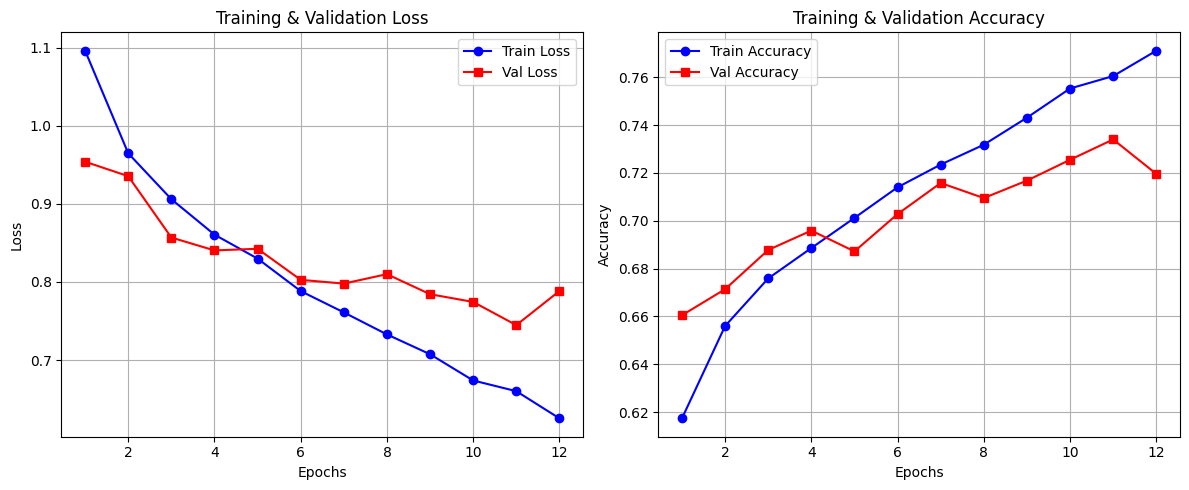

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

# Vẽ biểu đồ Train Accuracy và Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

plt.show()


In [46]:
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomDenseNet121, self).__init__()
        self.base_model = models.densenet121(pretrained=False)  # Không dùng pretrained=True vì đã có trọng số
        in_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomDenseNet121(num_classes=8).to(device)


state_dict = torch.load('/kaggle/working/best_model.pth', map_location=device)
model.load_state_dict(state_dict) 

model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-46-a3565f8865a2>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

CustomDenseNet121(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05,

In [40]:
def predict(model, test_loader):
    model.eval()  
    predictions = []
    image_ids = []

    with torch.no_grad(): 
        for images, img_id in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  
            
            predictions.extend(preds.cpu().numpy()) 
            image_ids.extend(img_id)  

    return image_ids, predictions

In [47]:
image_ids, preds = predict(model, test_loader)
class_mapping_inv = {v: k for k, v in train_dataset.class_mapping.items()}
pred_classes = [class_mapping_inv[p] for p in preds]

In [48]:
predict_df = pd.DataFrame({'image_id': image_ids, 'predicted_class': pred_classes})
predict_df.head(5)

,image_id,predicted_class
0,ISIC_0034321,BCC
1,ISIC_0034322,NV
2,ISIC_0034323,BCC
3,ISIC_0034324,NV
4,ISIC_0034325,NV


In [43]:
#groundtruth
test_gt = pd.read_csv('/kaggle/input/model-datatest-skincancer/test_gt_remove_unk.csv')
test_gt.head()

,image,diagnosis
0,ISIC_0034321,NV
1,ISIC_0034322,NV
2,ISIC_0034323,BCC
3,ISIC_0034324,NV
4,ISIC_0034325,NV


In [49]:
accuracy = (predict_df['predicted_class'] == test_gt['diagnosis']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5220


# Evaluation

In [50]:
test_gt.rename(columns={"image": "image_id", "diagnosis": "true_class"}, inplace=True)

In [51]:
data = predict_df.merge(test_gt, on="image_id")
data

,image_id,predicted_class,true_class
0,ISIC_0034321,BCC,NV
1,ISIC_0034322,NV,NV
2,ISIC_0034323,BCC,BCC
3,ISIC_0034324,NV,NV
4,ISIC_0034325,NV,NV
...,...,...,...
6186,ISIC_0073226,BCC,BCC
6187,ISIC_0073234,BKL,NV
6188,ISIC_0073236,BCC,SCC
6189,ISIC_0073243,BCC,BCC


In [52]:
misclassified_df = data[data['predicted_class'] != data['true_class']]
print(len(misclassified_df))

2959


In [53]:
import torch.nn.functional as F

def predict_with_prob(model, test_loader):
    model.eval()
    predictions = []
    image_ids = []
    probabilities = []

    with torch.no_grad():
        for images, img_id in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Convert logits thành xác suất
            max_probs, preds = torch.max(probs, 1)  

            predictions.extend(preds.cpu().numpy())
            image_ids.extend(img_id)
            probabilities.extend(max_probs.cpu().numpy())  # Lưu xác suất

    return image_ids, predictions, probabilities

# Gọi hàm predict
image_ids, preds, probs = predict_with_prob(model, test_loader)

# Tạo DataFrame với xác suất
submission_df = pd.DataFrame({'image_id': image_ids, 'predicted_class': pred_classes, 'probability': probs})

In [54]:
submission_df.head()

,image_id,predicted_class,probability
0,ISIC_0034321,BCC,0.972783
1,ISIC_0034322,NV,0.995025
2,ISIC_0034323,BCC,0.996109
3,ISIC_0034324,NV,0.999283
4,ISIC_0034325,NV,0.927527


In [55]:
uncertain_df = submission_df[(submission_df['probability'] >= 0.45) & (submission_df['probability'] <= 0.55)]
print(f"uncertain: {len(uncertain_df)}")
display(uncertain_df.head())

uncertain: 485


,image_id,predicted_class,probability
10,ISIC_0034332,BCC,0.453460
36,ISIC_0034360,BKL,0.453591
57,ISIC_0034382,BCC,0.533573
67,ISIC_0034394,NV,0.499924
75,ISIC_0034402,BCC,0.459327
